# Step 1. Get Data

In [ ]:
!pip install pytube
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56 kB 4.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pytube import YouTube
from pydub import AudioSegment
import os

In [ ]:
wav_path = "wav_data"

def download_and_convert_wav():
    if not os.path.exists(wav_path): os.mkdir(wav_path)
    singer_song = input("가수 - 제목: ")
    yt = YouTube(input("음원 유튜브 url: "))
    yt.streams.filter(only_audio=True).first().download(output_path=wav_path, filename=singer_song+".mp3")
    AudioSegment.from_file(os.path.join(wav_path, singer_song+".mp3")).export(os.path.join(wav_path, singer_song+".wav"), format="wav")
    os.remove(os.path.join(wav_path, singer_song+".mp3"))

In [ ]:
download_and_convert_wav()

가수 - 제목: 칼림바 - 캐논
음원 유튜브 url: https://youtu.be/X__ZUNGt70A


# Step 2. wav to midi (MT3)

In [ ]:
!apt-get update -qq && apt-get install -qq libfluidsynth1 build-essential libasound2-dev libjack-dev

!pip install nest-asyncio
!pip install pyfluidsynth
# pin CLU for python 3.7 compatibility
!pip install clu==0.0.7
# pin Orbax to use Checkpointer
!pip install orbax==0.0.2

# install t5x
!git clone --branch=main https://github.com/google-research/t5x
# pin T5X for python 3.7 compatibility
!cd t5x; git reset --hard 2e05ad41778c25521738418de805757bf2e41e9e; cd ..
!mv t5x t5x_tmp; mv t5x_tmp/* .; rm -r t5x_tmp
!sed -i 's:jax\[tpu\]:jax:' setup.py
!python3 -m pip install -e .

# install mt3
!git clone --branch=main https://github.com/magenta/mt3
!mv mt3 mt3_tmp; mv mt3_tmp/* .; rm -r mt3_tmp
!python3 -m pip install -e .

# downgrade jax and jaxlib
# TODO(iansimon): remove this once we can use the latest t5x
!pip install jax==0.3.15
!pip install jaxlib==0.3.15

# copy checkpoints
!gsutil -q -m cp -r gs://mt3/checkpoints .

# copy soundfont (originally from https://sites.google.com/site/soundfonts4u)
!gsutil -q -m cp gs://magentadata/soundfonts/SGM-v2.01-Sal-Guit-Bass-V1.3.sf2 .

import json
import IPython

Selecting previously unselected package libfluidsynth1:amd64.
(Reading database ... 155676 files and directories currently installed.)
Preparing to unpack .../libfluidsynth1_1.1.9-1_amd64.deb ...
Unpacking libfluidsynth1:amd64 (1.1.9-1) ...
Setting up libfluidsynth1:amd64 (1.1.9-1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.5) ...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92 kB 1.1 MB/s 
     |████████████████████████████████| 180 kB 67.3 MB/s 
     |████████████████████████████████| 77 kB 7.2 MB/s 
     |████████████████████████████████| 1.0 MB 54.2 MB/s 
     |████████████████████████████████| 145 kB 45.9 MB/s 
     |████████████████████████████████| 217 kB 65.8 MB/s 
     |███████████

<IPython.core.display.Javascript object>

#### Lib

In [ ]:
import functools
import os

import numpy as np
import tensorflow.compat.v2 as tf

import functools
import gin
import jax
import librosa
import note_seq
import seqio
import t5
import t5x

from mt3 import metrics_utils
from mt3 import models
from mt3 import network
from mt3 import note_sequences
from mt3 import preprocessors
from mt3 import spectrograms
from mt3 import vocabularies

from google.colab import files

import nest_asyncio

/usr/local/lib/python3.7/dist-packages/orbax/checkpoint/checkpoint_manager.py:30: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTree = type(jax.tree_structure(None))
/usr/local/lib/python3.7/dist-packages/orbax/checkpoint/transform_utils.py:26: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTree = type(jax.tree_structure(None))
/usr/local/lib/python3.7/dist-packages/orbax/checkpoint/pytree_checkpointer.py:38: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTree = type(jax.tree_structure(None))
/content/t5x/partitioning.py:40: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))
/content/t5x/checkpoints

In [ ]:
nest_asyncio.apply()

In [ ]:
SAMPLE_RATE = 16000
SF2_PATH = 'SGM-v2.01-Sal-Guit-Bass-V1.3.sf2'

In [ ]:
def upload_audio(sample_rate):
  data = list(files.upload().values())
  if len(data) > 1:
    print('Multiple files uploaded; using only one.')
  return note_seq.audio_io.wav_data_to_samples_librosa(
    data[0], sample_rate=sample_rate)

In [ ]:
class InferenceModel(object):
  """Wrapper of T5X model for music transcription."""

  def __init__(self, checkpoint_path, model_type='mt3'):

    # Model Constants.
    if model_type == 'ismir2021':
      num_velocity_bins = 127
      self.encoding_spec = note_sequences.NoteEncodingSpec
      self.inputs_length = 512
    elif model_type == 'mt3':
      num_velocity_bins = 1
      self.encoding_spec = note_sequences.NoteEncodingWithTiesSpec
      self.inputs_length = 256
    else:
      raise ValueError('unknown model_type: %s' % model_type)

    gin_files = ['/content/mt3/gin/model.gin',
                 f'/content/mt3/gin/{model_type}.gin']

    self.batch_size = 8
    self.outputs_length = 1024
    self.sequence_length = {'inputs': self.inputs_length, 
                            'targets': self.outputs_length}

    self.partitioner = t5x.partitioning.PjitPartitioner(
        num_partitions=1)

    # Build Codecs and Vocabularies.
    self.spectrogram_config = spectrograms.SpectrogramConfig()
    self.codec = vocabularies.build_codec(
        vocab_config=vocabularies.VocabularyConfig(
            num_velocity_bins=num_velocity_bins))
    self.vocabulary = vocabularies.vocabulary_from_codec(self.codec)
    self.output_features = {
        'inputs': seqio.ContinuousFeature(dtype=tf.float32, rank=2),
        'targets': seqio.Feature(vocabulary=self.vocabulary),
    }

    # Create a T5X model.
    self._parse_gin(gin_files)
    self.model = self._load_model()

    # Restore from checkpoint.
    self.restore_from_checkpoint(checkpoint_path)

  @property
  def input_shapes(self):
    return {
          'encoder_input_tokens': (self.batch_size, self.inputs_length),
          'decoder_input_tokens': (self.batch_size, self.outputs_length)
    }

  def _parse_gin(self, gin_files):
    """Parse gin files used to train the model."""
    gin_bindings = [
        'from __gin__ import dynamic_registration',
        'from mt3 import vocabularies',
        'VOCAB_CONFIG=@vocabularies.VocabularyConfig()',
        'vocabularies.VocabularyConfig.num_velocity_bins=%NUM_VELOCITY_BINS'
    ]
    with gin.unlock_config():
      gin.parse_config_files_and_bindings(
          gin_files, gin_bindings, finalize_config=False)

  def _load_model(self):
    """Load up a T5X `Model` after parsing training gin config."""
    model_config = gin.get_configurable(network.T5Config)()
    module = network.Transformer(config=model_config)
    return models.ContinuousInputsEncoderDecoderModel(
        module=module,
        input_vocabulary=self.output_features['inputs'].vocabulary,
        output_vocabulary=self.output_features['targets'].vocabulary,
        optimizer_def=t5x.adafactor.Adafactor(decay_rate=0.8, step_offset=0),
        input_depth=spectrograms.input_depth(self.spectrogram_config))


  def restore_from_checkpoint(self, checkpoint_path):
    train_state_initializer = t5x.utils.TrainStateInitializer(
      optimizer_def=self.model.optimizer_def,
      init_fn=self.model.get_initial_variables,
      input_shapes=self.input_shapes,
      partitioner=self.partitioner)

    restore_checkpoint_cfg = t5x.utils.RestoreCheckpointConfig(
        path=checkpoint_path, mode='specific', dtype='float32')

    train_state_axes = train_state_initializer.train_state_axes
    self._predict_fn = self._get_predict_fn(train_state_axes)
    self._train_state = train_state_initializer.from_checkpoint_or_scratch(
        [restore_checkpoint_cfg], init_rng=jax.random.PRNGKey(0))

  @functools.lru_cache()
  def _get_predict_fn(self, train_state_axes):
    def partial_predict_fn(params, batch, decode_rng):
      return self.model.predict_batch_with_aux(
          params, batch, decoder_params={'decode_rng': None})
    return self.partitioner.partition(
        partial_predict_fn,
        in_axis_resources=(
            train_state_axes.params,
            t5x.partitioning.PartitionSpec('data',), None),
        out_axis_resources=t5x.partitioning.PartitionSpec('data',)
    )

  def predict_tokens(self, batch, seed=0):
    prediction, _ = self._predict_fn(
        self._train_state.params, batch, jax.random.PRNGKey(seed))
    return self.vocabulary.decode_tf(prediction).numpy()

  def __call__(self, audio):
    ds = self.audio_to_dataset(audio)
    ds = self.preprocess(ds)

    model_ds = self.model.FEATURE_CONVERTER_CLS(pack=False)(
        ds, task_feature_lengths=self.sequence_length)
    model_ds = model_ds.batch(self.batch_size)

    inferences = (tokens for batch in model_ds.as_numpy_iterator()
                  for tokens in self.predict_tokens(batch))

    predictions = []
    for example, tokens in zip(ds.as_numpy_iterator(), inferences):
      predictions.append(self.postprocess(tokens, example))

    result = metrics_utils.event_predictions_to_ns(
        predictions, codec=self.codec, encoding_spec=self.encoding_spec)
    return result['est_ns']

  def audio_to_dataset(self, audio):
    frames, frame_times = self._audio_to_frames(audio)
    return tf.data.Dataset.from_tensors({
        'inputs': frames,
        'input_times': frame_times,
    })

  def _audio_to_frames(self, audio):
    frame_size = self.spectrogram_config.hop_width
    padding = [0, frame_size - len(audio) % frame_size]
    audio = np.pad(audio, padding, mode='constant')
    frames = spectrograms.split_audio(audio, self.spectrogram_config)
    num_frames = len(audio) // frame_size
    times = np.arange(num_frames) / self.spectrogram_config.frames_per_second
    return frames, times

  def preprocess(self, ds):
    pp_chain = [
        functools.partial(
            t5.data.preprocessors.split_tokens_to_inputs_length,
            sequence_length=self.sequence_length,
            output_features=self.output_features,
            feature_key='inputs',
            additional_feature_keys=['input_times']),
        preprocessors.add_dummy_targets,
        functools.partial(
            preprocessors.compute_spectrograms,
            spectrogram_config=self.spectrogram_config)
    ]
    for pp in pp_chain:
      ds = pp(ds)
    return ds

  def postprocess(self, tokens, example):
    tokens = self._trim_eos(tokens)
    start_time = example['input_times'][0]
    start_time -= start_time % (1 / self.codec.steps_per_second)
    return {
        'est_tokens': tokens,
        'start_time': start_time,
        'raw_inputs': []
    }

  @staticmethod
  def _trim_eos(tokens):
    tokens = np.array(tokens, np.int32)
    if vocabularies.DECODED_EOS_ID in tokens:
      tokens = tokens[:np.argmax(tokens == vocabularies.DECODED_EOS_ID)]
    return tokens

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#title Load Model
#markdown The `ismir2021` model transcribes piano only, with note velocities.
#markdown The `mt3` model transcribes multiple simultaneous instruments,
#markdown but without velocities.

MODEL = "mt3" #param["ismir2021", "mt3"]

checkpoint_path = f'/content/checkpoints/{MODEL}/'

inference_model = InferenceModel(checkpoint_path, MODEL)


In [ ]:
audio = upload_audio(sample_rate=SAMPLE_RATE)


note_seq.notebook_utils.colab_play(audio, sample_rate=SAMPLE_RATE)

<IPython.core.display.Javascript object>

Saving 칼림바 - 캐논.wav to 칼림바 - 캐논.wav


<IPython.core.display.Javascript object>

In [ ]:
est_ns = inference_model(audio)

note_seq.play_sequence(est_ns, synth=note_seq.fluidsynth, 
                       sample_rate=SAMPLE_RATE, sf2_path=SF2_PATH)
note_seq.plot_sequence(est_ns)

In [ ]:
note_seq.sequence_proto_to_midi_file(est_ns, '/tmp/transcribed.mid')
files.download('/tmp/transcribed.mid')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.upload()

Saving transcribed.mid to transcribed.mid


{'transcribed.mid': b"MThd\x00\x00\x00\x06\x00\x01\x00\x04\x00\xdcMTrk\x00\x00\x00\x13\x00\xffQ\x03\x07\xa1 \x00\xffX\x04\x04\x02\x18\x08\x01\xff/\x00MTrk\x00\x00\x0b\x99\x00\xc0\x08\x8eW\x907\x7f\x1f7\x00\x00<\x7f'<\x00\x00@\x7f\x16@\x00\x00@\x7f\x16C\x7f\x85E@\x00\x00C\x00\x81'J\x7f0G\x7f\x1bJ\x00\x85\x14G\x00\x810T\x7f\x876L\x7f\x00T\x00(L\x00\x00O\x7f4O\x00\x05S\x7f\x84@S\x00\x824H\x7fTE\x7f\x00H\x00\x83~E\x00\x82\x15H\x7f1L\x7f\x04H\x001C\x7f\x04L\x00\x86cH\x7f\x04C\x00\x1bJ\x7f\x04H\x005E\x7f\x04J\x00\x83NE\x00\x83\x11O\x7fFO\x00\x04S\x7f\x83+S\x00\x83E9\x7f\x00<\x7f\x00@\x7f\x0eH\x7f\x81`@\x00\x00@\x7f\x81O9\x00\x00<\x00\x00@\x00\x00H\x00'L\x7f\x83NL\x00\x0eS\x7f\x81WS\x00\rO\x7f\x81\x1fO\x00OJ\x7f\x83<J\x00\x16H\x7f\x81jH\x00\rE\x7f\x81eE\x00\x04L\x7f\x83[L\x00\x00L\x7f\x81nL\x00\x04G\x7f>G\x00\x81+E\x7f\x830E\x00\x11E\x7f\rM\x7f\x81XE\x00\x12J\x7f\x1eJ\x00\x00M\x00\x8109\x7f$9\x00\x00<\x7f\x83N<\x00\x08@\x7f\x81\\@\x00\tT\x7f\x81\x1aT\x00aL\x7f\x83<L\x00\x12Q\x7f\x814Q\x005J\x

# Step 3. Scoring

In [ ]:
!pip install mido
!pip install librosa
!pip music21

In [ ]:
from mido import MidiFile, MidiTrack, Message
import mido
import IPython
import matplotlib.pyplot as plt
import librosa.display
from IPython import *
from music21 import *
from music21 import converter, instrument, note, chord, stream, midi

In [ ]:
!add-apt-repository ppa:mscore-ubuntu/mscore-stable -y
!apt-get update
!apt-get install musescore

!apt-get install xvfb

!sh -e /etc/init.d/x11-common start

import os
os.putenv('DISPLAY', ':99.0')

!start-stop-daemon --start --pidfile /var/run/xvfb.pid --make-pidfile --background --exec /usr/bin/Xvfb -- :99 -screen 0 1024x768x24 -ac +extension GLX +render -noreset

us = environment.UserSettings()
us['musescoreDirectPNGPath'] = '/usr/bin/mscore'
us['directoryScratch'] = '/tmp'

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://ppa.launchpad.net/mscore-ub

In [ ]:
# Melody-RNN은 8비트 정수 시퀀스를 받음
# MELODY_NOTE_ON = [0, 127] # (note on at that MIDI pitch)
MELODY_NOTE_OFF = 128 # (stop playing all previous notes)
MELODY_NO_EVENT = 129 # (no change from previous event)

In [ ]:
def streamToNoteArray(stream):
    # Convert a Music21 sequence to a numpy array if int8s into Melody-RNN format
    # Part1. extract from stream
    total_length = np.int(np.round(stream.flat.highestTime / 0.25)) # in semiquavers
    stream_list = []
    for element in stream.flat:
        if isinstance(element, note.Note):
            stream_list.append([np.round(element.offset / 0.25), np.round(element.quarterLength / 0.25), element.pitch.midi])
        elif isinstance(element, chord.Chord):
            stream_list.append([np.round(element.offset / 0.25), np.round(element.quarterLength / 0.25), element.sortAscending().pitches[-1].midi])
    np_stream_list = np.array(stream_list, dtype=np.int)
    df = pd.DataFrame({'pos': np_stream_list.T[0], 'dur': np_stream_list.T[1], 'pitch': np_stream_list.T[2]})
    df = df.sort_values(['pos','pitch'], ascending=[True, False]) # sort the dataframe properly
    df = df.drop_duplicates(subset=['pos']) # drop duplicate values
    # part 2, convert into a sequence of note events
    output = np.zeros(total_length+1, dtype=np.int16) + np.int16(MELODY_NO_EVENT)  # set array full of no events by default.
    # Fill in the output list
    for i in range(total_length):
        if not df[df["pos"]==i].empty:
            n = df[df["pos"]==i].iloc[0] # pick the highest pitch at each semiquaver
            output[i] = n["pitch"] # set note on
            output[i+n.dur] = MELODY_NOTE_OFF
    return output
def noteArrayToDataFrame(note_array):
    # Convert a numpy array containing a Melody-RNN sequence into a DataFrame
    df = pd.DataFrame({"code": note_array})
    df["offset"] = df.index
    df["duration"] = df.index
    df = df[df["code"]!=MELODY_NO_EVENT]
    df["duration"] = df["duration"].diff(-1)*-1*0.25 # calculate durations and change to quarter note fractions
    df = df.fillna(0.25)
    return df[["code", "duration"]]
def noteArrayToStream(note_array):
    # Convert numpy array containg a Melody-RNN sequence into a music21 stream
    df = noteArrayToDataFrame(note_array)
    melody_stream = stream.Stream()
    for index, row in df.iterrows():
        if row["code"] == MELODY_NO_EVENT:
            new_note = note.Rest() 
        elif row["code"] == MELODY_NOTE_OFF:
            new_note = note.Rest()
        else:
            new_note = note.Note(row.code)
        new_note.quarterLength = row["duration"]
        melody_stream.append(new_note)
    return melody_stream

In [ ]:
wm_mid = converter.parse("./transcribed.mid")

meter: WARNING: Found a messed up beam pair <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>, at index 6 of 
[<music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/continue>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/continue>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>>, <music21.beam.Beams <music21.beam.Beam 1/stop>>, <music21.beam.Beams <music21.beam.Beam 1/start>/<music21.beam.Beam 2/partial/right>>, <music21.beam.Beams <music21.beam.Beam 1/stop>/<music21.beam.Beam 2/stop>>]


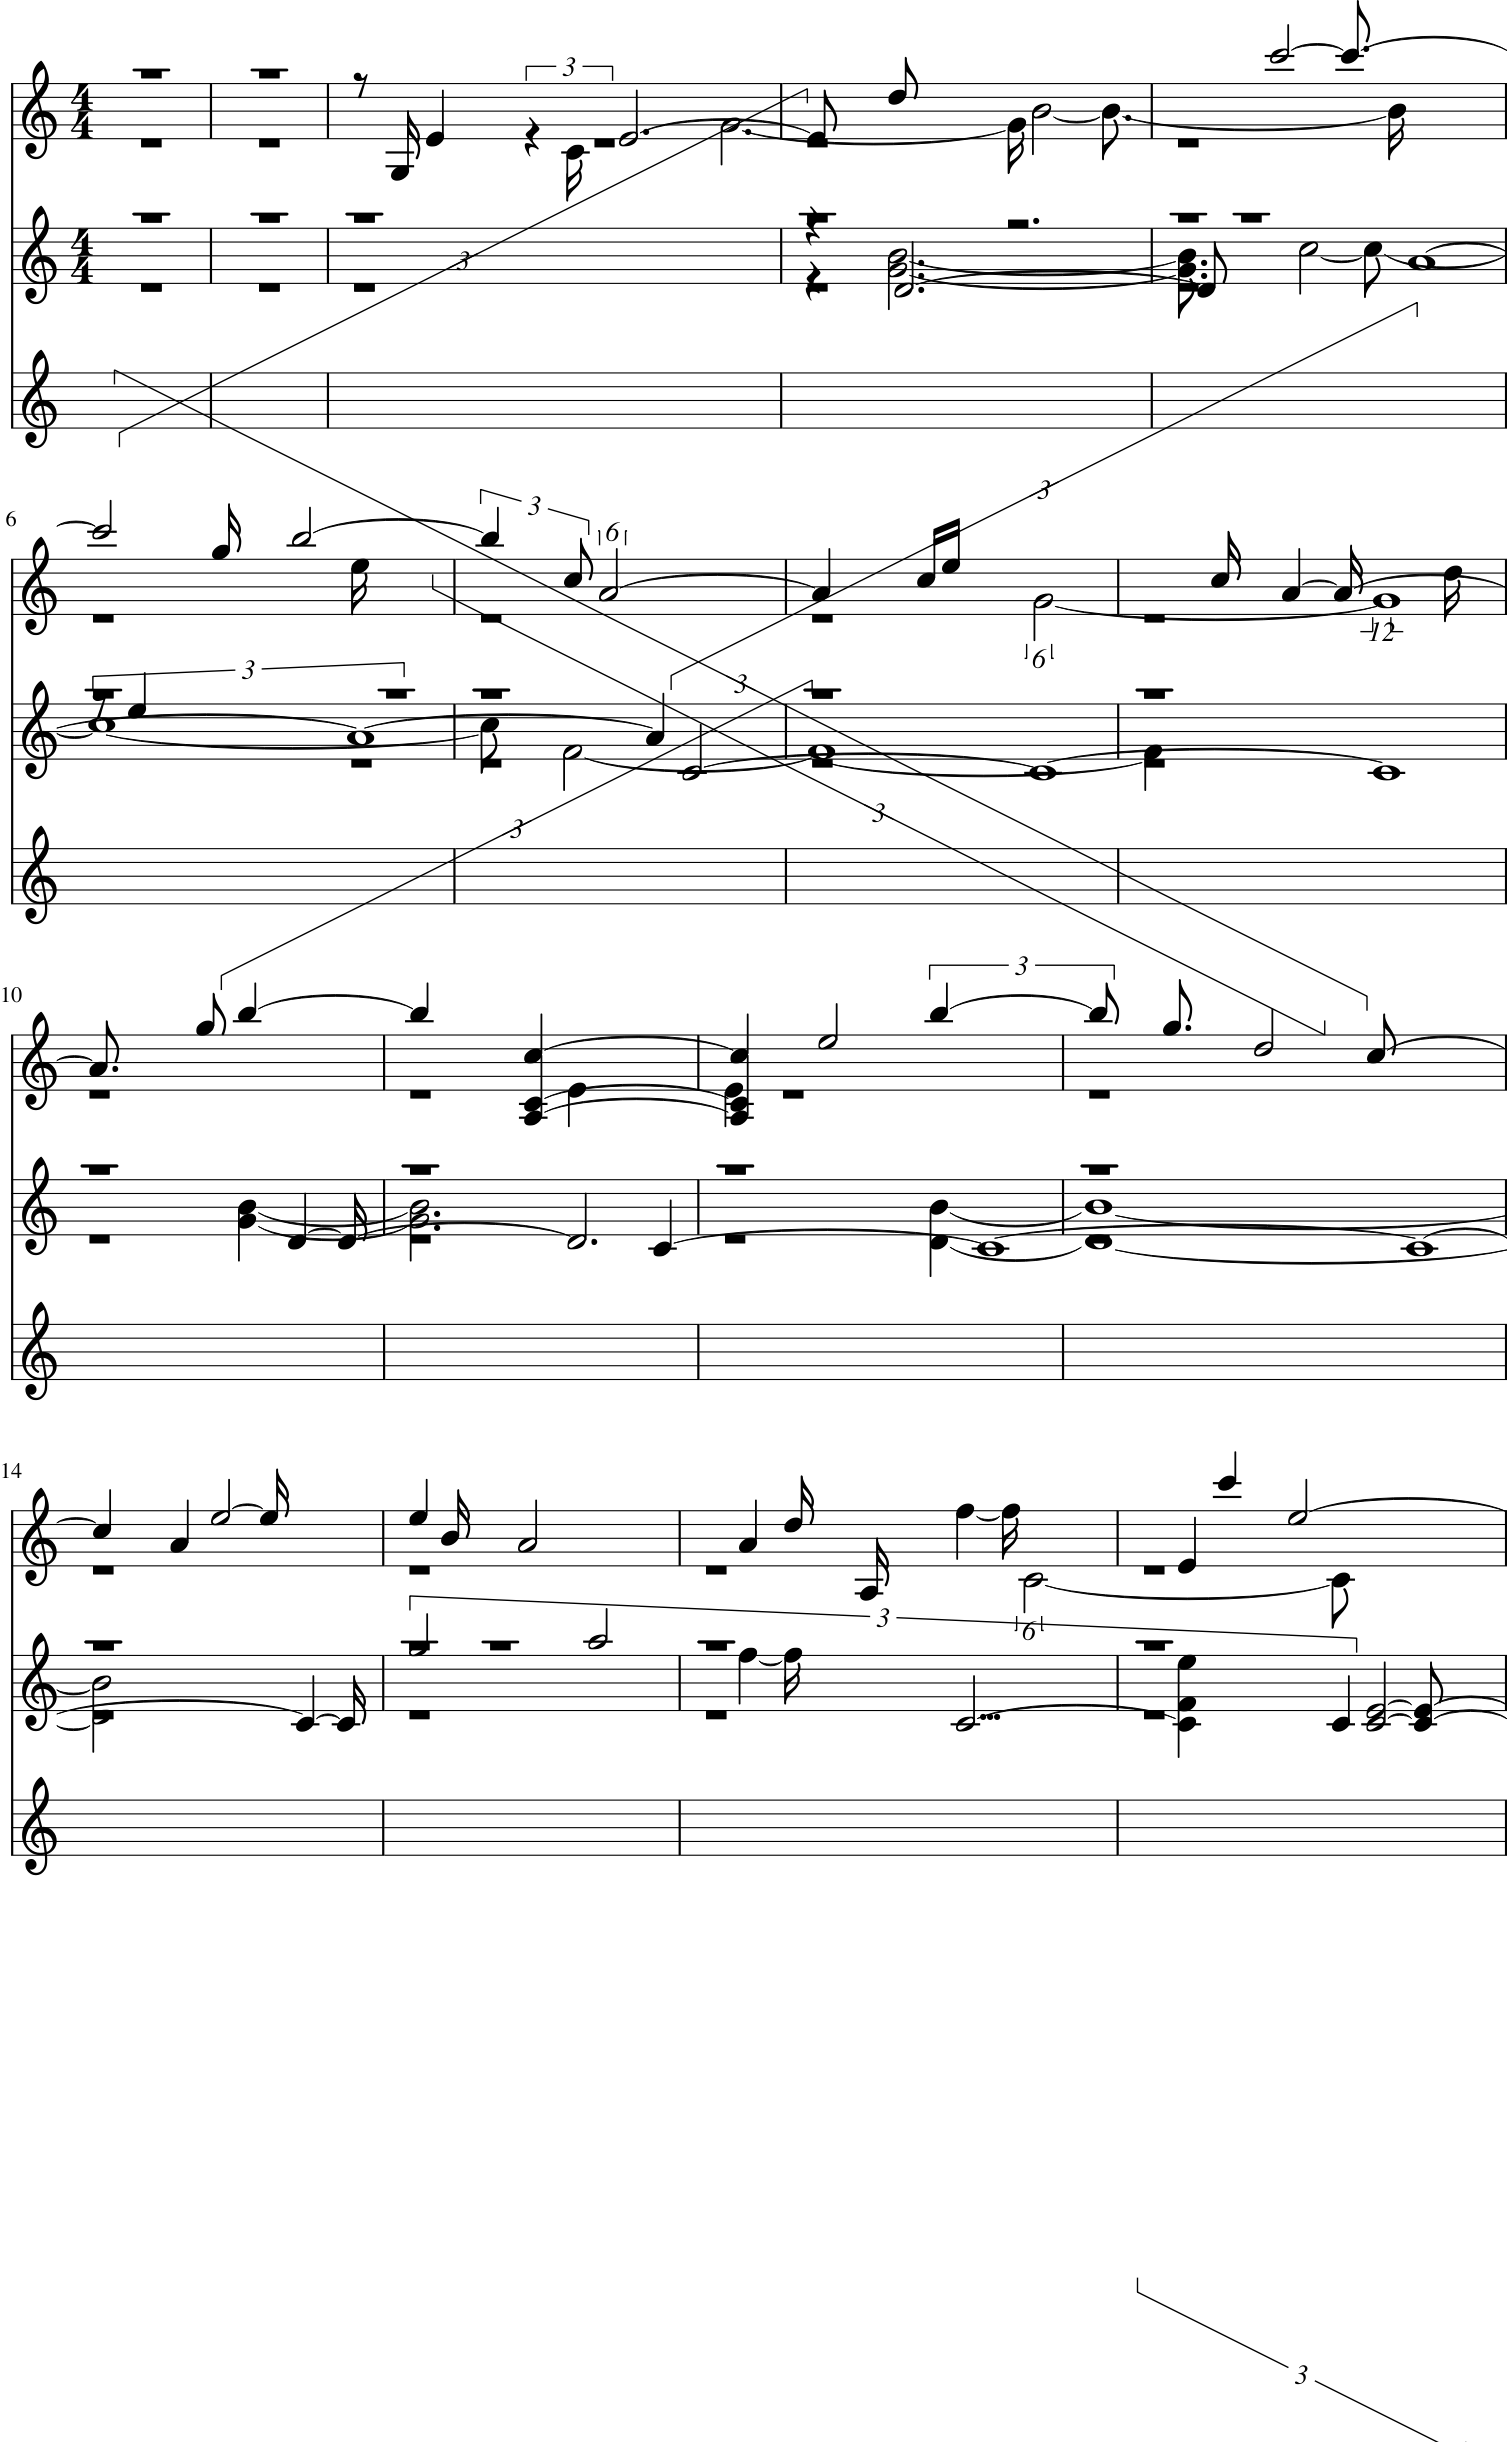

In [ ]:
wm_mid.show()

In [ ]:
import pandas as pd

In [ ]:
wm_mel_rnn = streamToNoteArray(wm_mid)
print(wm_mel_rnn)

[129 129 129 ... 129 129 128]


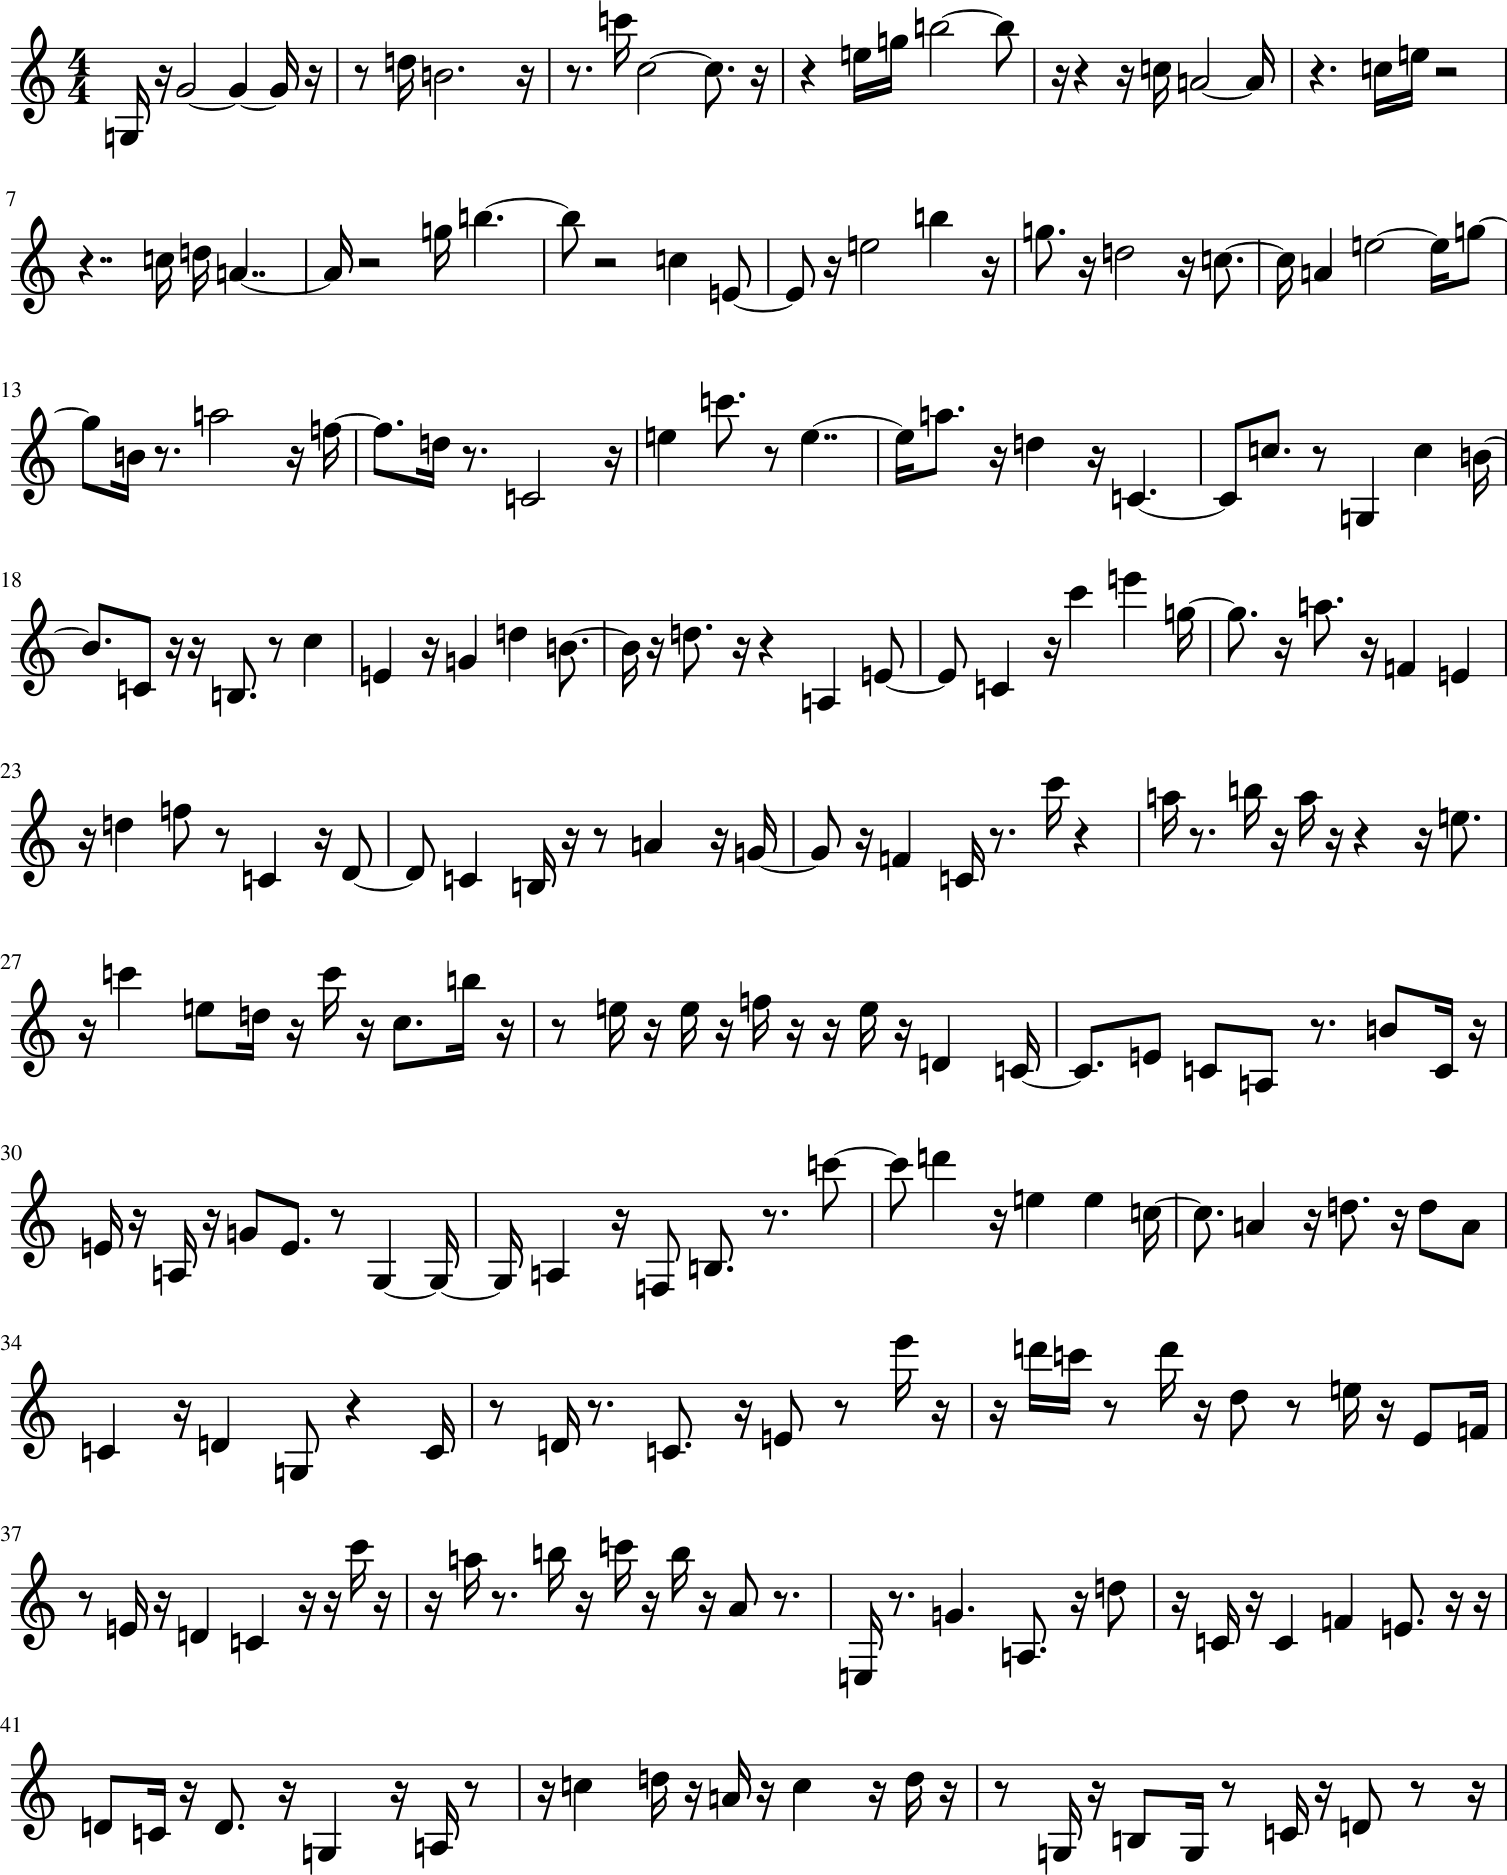

In [ ]:
noteArrayToStream(wm_mel_rnn).show()